# Test pymc3

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
test = 392
ctrl = 15

In [3]:
with pm.Model() as m:
    
    
    conv_ctrl = pm.Beta('conv_ctrl', alpha=1, beta=1)
    success_ctrl = pm.Binomial('success_ctrl', n = 23522, p = conv_ctrl, observed = ctrl)
    avg_tkt_ctrl = pm.Normal('tkt_ctrl', mu = 1_000, sigma=200)
    rev_ctrl = success_ctrl * avg_tkt_ctrl
    
    conv_test = pm.Beta('conv_test', alpha=1, beta=1)
    success_test = pm.Binomial('success_test', n = 211710, p = conv_test, observed = test)
    avg_tkt_test = pm.Normal('tkt_tst', mu = 1_000, sigma=200)
    rev_test = success_test * avg_tkt_test
    
    delta_conv = pm.Deterministic('delta_conv', (conv_test - conv_ctrl) / conv_ctrl)
    delta_rev = pm.Deterministic('delta_rev', (rev_test - rev_ctrl) / rev_ctrl)
    

In [4]:
with m:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(draws=2_000)

C:\Anaconda3\envs\prob\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tkt_tst, conv_test, tkt_ctrl, conv_ctrl]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [5]:
arviz_data = az.from_pymc3(trace=trace, model=m, prior=prior)

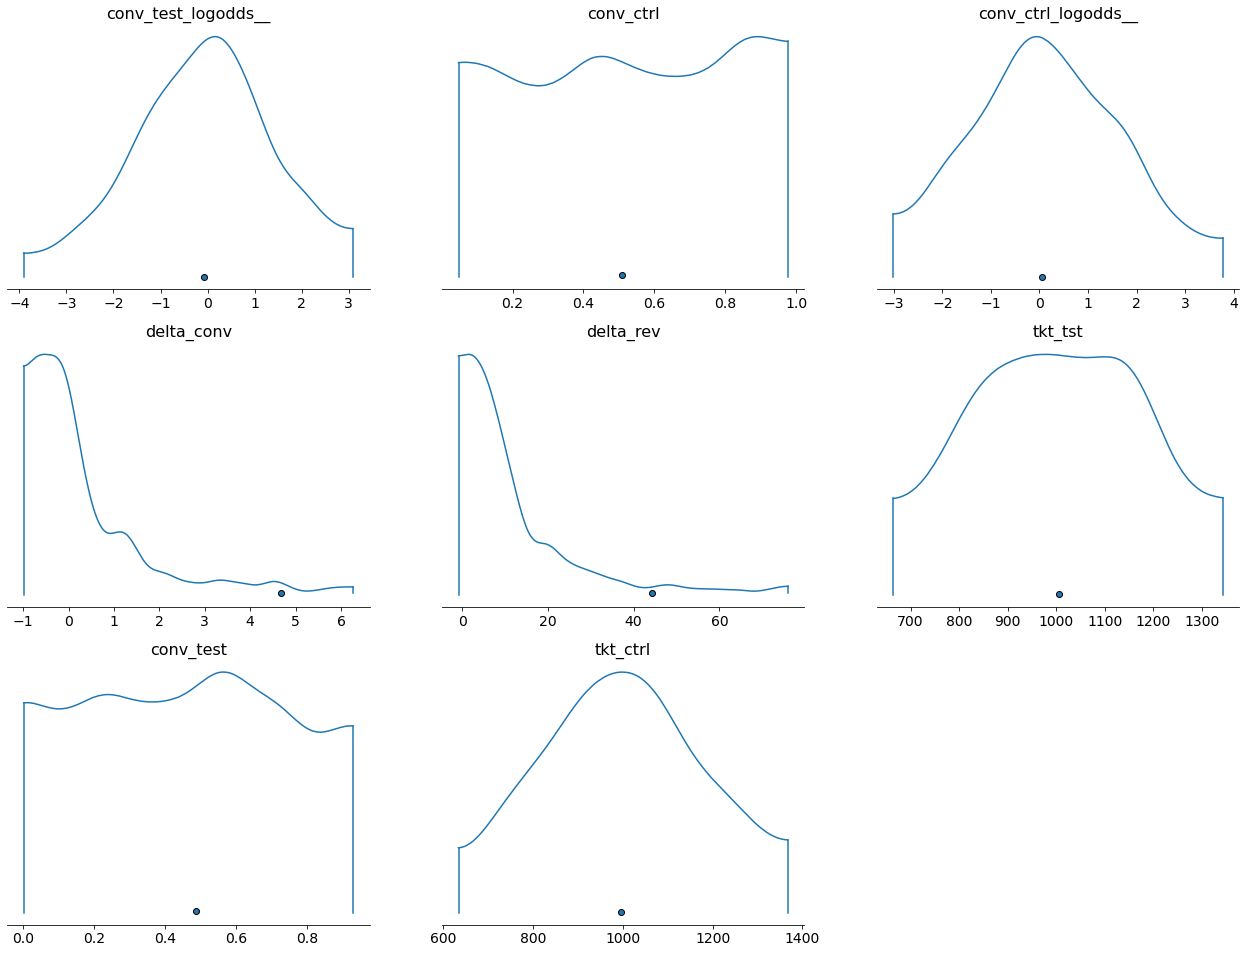

In [6]:
az.plot_density(arviz_data, group='prior');

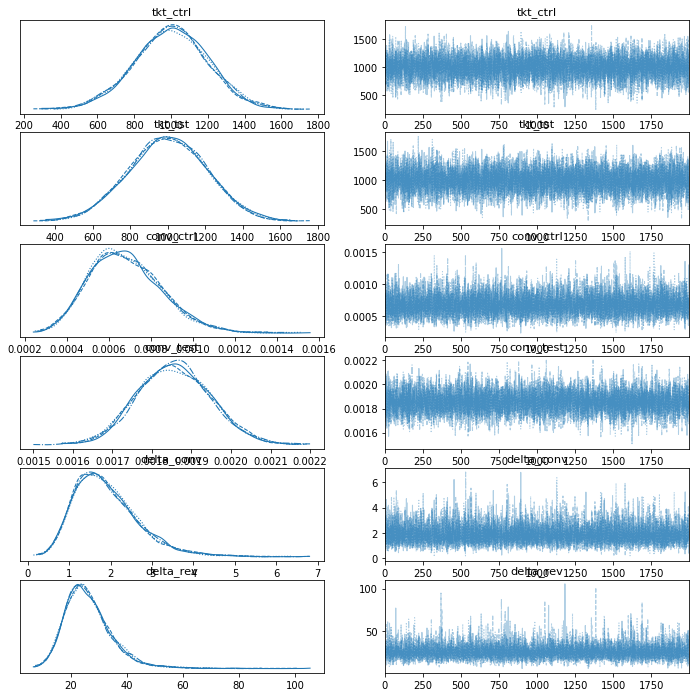

In [7]:
az.plot_trace(arviz_data);

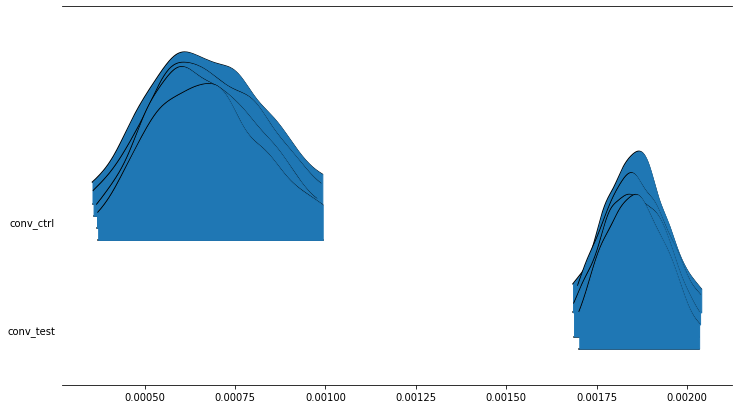

In [8]:
az.plot_forest(arviz_data, kind='ridgeplot', var_names=['conv_ctrl', 'conv_test']);

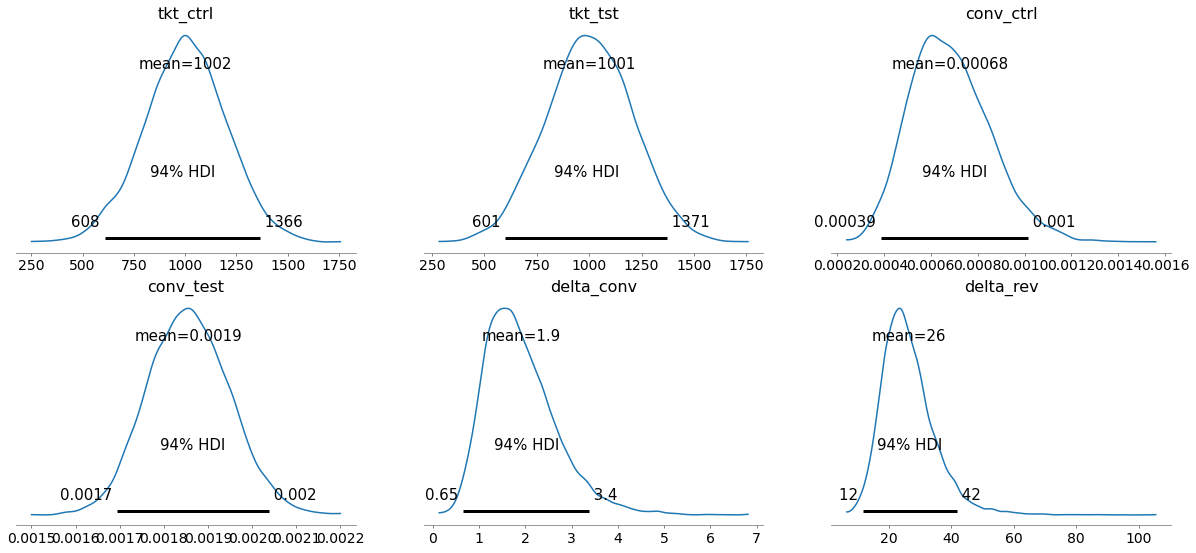

In [9]:
az.plot_posterior(arviz_data);

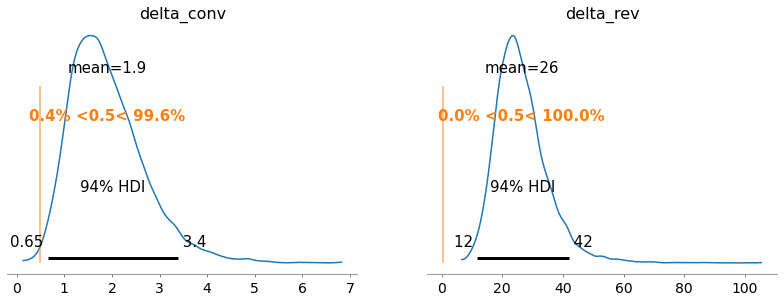

In [10]:
az.plot_posterior(arviz_data, ref_val=0.5,var_names=['delta_conv', 'delta_rev']);

In [11]:
az.summary(arviz_data, hdi_prob=.5, )

,mean,sd,hdi_25%,hdi_75%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tkt_ctrl,1001.732,200.168,855.514,1119.189,1.753,1.243,13087.0,6102.0,1.0
tkt_tst,1000.770,205.904,874.135,1151.838,1.746,1.259,13894.0,6074.0,1.0
conv_ctrl,0.001,0.000,0.001,0.001,0.000,0.000,13233.0,6107.0,1.0
conv_test,0.002,0.000,0.002,0.002,0.000,0.000,10393.0,6264.0,1.0
delta_conv,1.901,0.783,1.092,2.019,0.007,0.006,12799.0,6453.0,1.0
delta_rev,26.339,8.776,18.421,28.225,0.086,0.071,12596.0,6188.0,1.0


# Test Prophet

In [32]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import numpy as np

In [57]:
# make dummy data
ts = pd.date_range(start='2020-01-01', periods=720, )
df = pd.DataFrame({
    'ds' : ts,
})
df['y'] = df.index + np.random.normal(size=720, loc=1, scale = 10)

In [58]:
# fit model
m = Prophet()
m.fit(df)

15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# make future dataframe
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1080,2022-12-16
1081,2022-12-17
1082,2022-12-18
1083,2022-12-19
1084,2022-12-20


In [60]:
# forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1080,2022-12-16,1085.091642,1071.792688,1098.101251
1081,2022-12-17,1086.760306,1074.138609,1100.045148
1082,2022-12-18,1085.013470,1072.309505,1097.893113
1083,2022-12-19,1088.570809,1076.033123,1102.539303
1084,2022-12-20,1089.451449,1076.045514,1102.585268


## Plot

In [61]:
plot_plotly(m, forecast)

In [62]:
plot_components_plotly(m, forecast)